In [ ]:
class YOLOv1(torch.nn.Module):
    def __init__(self, VGG16):
        super(YOLOv1, self).__init__()
        self.backbone = VGG16
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1470)
        )

    # 정전파 
    def forward(self, x):
        x = self.backbone(x)
        x = self.conv(x)
        x = self.linear(x)
        x = torch.reshape(x, (-1 ,7, 7, 30))
        return x

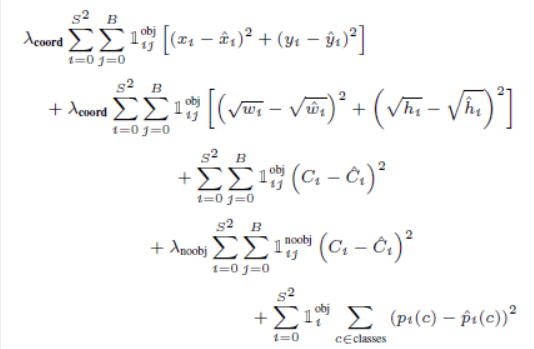

In [ ]:
import torch
import torch.nn as nn
from utils import intersection_over_union as iou

class YOLOv1Loss(nn.Module):
    def __init__(self, S=7, B=2, C=20, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOv1Loss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss()
    
    def forward(self, predictions, target):
        # 로스 구하기 위한 사전 작업
        exists_box = target[..., 20].unsqueeze(-1)  # obj가 있음 = confidence 1
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        
        # IOU 계산
        iou0 = iou(predictions[..., 21:25], target[..., 21:25])
        iou1 = iou(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou0.unsqueeze(0), iou1.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        
        # 박스 정의
        box_predictions = exists_box * ((1 - bestbox) * predictions[..., 21:25] + bestbox * predictions[..., 26:30])
        box_targets = exists_box * target[..., 21:25]
        # 박스 제곱근 처리
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sign(box_target[..., 2:4]) * torch.sqrt(torch.abs(target[..., 2:4] + 1e-6))
        # 박스 로스
        box_loss = self.mse(
            box_predictions,
            box_targets)
        )

        # 예측 객체 존재 정의
        pred_confidence_score = (1 - bestbox) * predictions[..., 20:21] + bestbox * predictions[..., 25:26]
        
        # 객체 존재 손실
        object_loss = self.mse(
            exists_box * pred_confidence_score, 
            exists_box * target[..., 20:21]
        )
        
        # 객체 미존재 손실
        no_object_loss = self.mse(
            (1 - exists_box) * pred_confidence_score, 
            (1 - exists_box) * target[..., 20:21]
        )
        
        # 클래스 손실
        class_loss = self.mse(
            exists_box * predictions[..., :20], 
            exists_box * target[..., :20])
        
        # 전체 손실 계산
        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )
        
        return loss


작성하면서 어려운 부분.
dim
start_dim
end_dim
개념은 아는데 왜 저 상황에 왜 사용되는지는 머릿속에 그려지질 않는다.
텐서의 이해도가 부족하다 생각 함.